# Quantum State Teleportation and Distribution

<em style="color:gray;">Copyright (c) 2025 QuAIR team. All Rights Reserved.</em>

In this tutorial, we will introduce **Quantum State Teleportation and Distribution**. Specifically, we will cover the background and research motivations of quantum state teleportation, the one-way LOCC protocol and its mathematical foundations, and practical implementations in **QuAIRKit**. Additionally, we will discuss the theoretical basis of W‑state distribution and its implementation in **QuAIRKit**.

**Table of Contents**

- [Introduction](#introduction)
  - [Background](#background)  
  - [Motivation](#motivation)  
- [One-way LOCC](#one-way-locc)  
  - [Central Hub Model for One-way LOCC](#central-hub-model-for-one-way-locc)
  - [Mathematical Representation of Central Hub Model](#mathematical-representation-of-the-central-hub-model)  
- [Single Qubit Teleportation](#single-qubit-teleportation)
  - [Mathematical Proof](#mathematical-proof-of-teleportation)
  - [QuAIRKit Implementation](#quairkit-implementation)
- [W-state Distribution](#w-state-distribution)

In [1]:
import torch
import quairkit as qkit
from quairkit import Circuit, to_state
from quairkit.database import *
from quairkit.operator import *
from quairkit.qinfo import *

qkit.set_dtype('complex128')

## Introduction

### Background
Quantum state teleportation is a process whereby the quantum information—that is, the complete quantum state—of a particle is transferred from one location (commonly called the sender, or “Alice”) to another (the receiver, or “Bob”), without physically sending the particle itself[1]. First proposed in the seminal paper by Bennett *et al.* in 1993[2], it has become a cornerstone protocol in quantum information science. Unlike science-fiction “beaming” of objects or people, quantum teleportation deals solely with the state information, which is then used to reconstruct an identical state on a distant system.

Quantum teleportation relies on several key components that work together to transfer quantum states. 

The quantum circuit shown in following figure gives a more precise description of quantum teleportation[1].

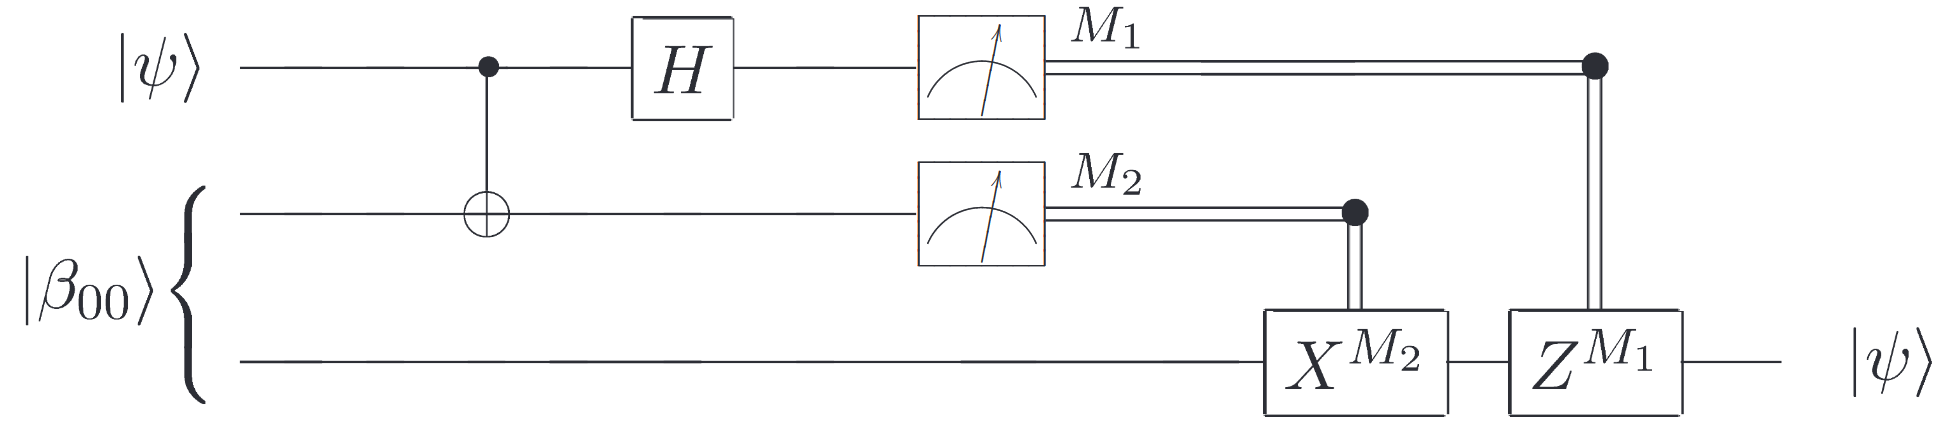



The two top lines represent Alice’s system, while the bottom line is Bob’s system. The meters represent measurement, and the double lines coming out of them carry classical bits (recall that single lines denote qubits).

First, **entanglement** is established between two quantum systems (for example, qubits) by preparing them in a maximally entangled Bell state, such as

$$
|\Phi^+\rangle = \frac{1}{\sqrt{2}} \, (|00\rangle + |11\rangle).\tag{1}
$$

This shared entangled pair is distributed between Alice and Bob, creating a quantum channel that connects them. Next, Alice takes the unknown quantum state she wants to teleport, namely

$$
|\psi\rangle = \alpha|0\rangle + \beta|1\rangle,\tag{2}
$$

and performs a **Bell-state measurement (BSM)** on this state combined with her half of the entangled pair. This measurement projects the combined state onto one of the four Bell states. Although the outcome is random, it encodes the precise transformation that Bob needs to apply to recover the original state.

After the measurement, Alice sends the two classical bits—which represent her measurement result—to Bob via a classical communication channel. Finally, Bob uses these bits to perform a **conditional unitary transformation** (which might be the identity, a bit-flip $X$, a phase-flip $Z$, or both $XZ$) on his half of the entangled pair. This corrects the state of Bob’s qubit, reconstructing exactly the state $|\psi\rangle$ that Alice intended to send.

In summary, the protocol involves:
- **Pre-sharing entanglement:** Alice and Bob share a Bell state.
- **Measurement and Communication:** Alice performs a Bell measurement on her unknown qubit $|\psi\rangle_C$ and her entangled qubit, then sends the two classical bits (the measurement outcome) to Bob.
- **State Reconstruction:** Bob applies the corresponding unitary operation to his qubit so that it assumes the state $|\psi\rangle$.

### Motivation
Quantum teleportation lies at the heart of quantum information science, serving not only as a cornerstone for practical implementations—such as long-distance quantum communication and distributed quantum computing—but also as an indispensable theoretical tool for simplifying and characterizing complex adaptive protocols. By exploiting entanglement and classical communication, teleportation enables one to map arbitrary quantum channels into a block form through the so-called “teleportation stretching” technique, effectively linearizing otherwise intricate adaptive processes into a nonadaptive structure with a single effective resource state. This approach is especially powerful for teleportation-covariant channels—including Pauli, erasure, and Gaussian channels—where the reduction of adaptive protocols allows for the rigorous derivation of ultimate capacity bounds in both continuous-variable (CV) and discrete-variable (DV) quantum key distribution under point-to-point lossy, multipoint, repeater-assisted, and network configurations [5–13]. In essence, teleportation stretching transforms the challenge of optimizing over all possible local operations and classical communications (LOCC) into a far more tractable problem of channel simulation, thereby paving the way for tight bounds on secret-key capacities and, more broadly, revealing the fundamental performance limits of quantum networks.

Beyond communication, quantum teleportation has become a foundational resource in quantum metrology, channel discrimination, and resource theories of quantum processors. By extending teleportation channel simulation techniques to metrological tasks, researchers have demonstrated that adaptive noise estimation protocols can be studied within a simplified “stretched” framework, yielding ultimate precision limits for any teleportation-covariant noise model [14–16]. Similarly, the theory of channel discrimination benefits from teleportation-based methods to establish fundamental error exponents and bounds when distinguishing between different quantum processes [17–18]. Moreover, port-based teleportation—a variant that eliminates the need for a correcting unitary at the receiver’s end—has been pivotal in understanding the limits of programmable quantum processors, optimizing their design, and quantifying the resources required for universal programmability [19–22]. Finally, quantum teleportation not only facilitates operational tasks but also provides deep insight into diverse physical phenomena, from quantum catalysis and decoherence to direct wavefunction measurement and macroscopic quantum effects, thereby highlighting its dual role as both a practical protocol and a lens through which the subtleties of quantum mechanics can be explored [22–28]. Further elaboration on the above content is available in review article [30].






## One-way LOCC

The set of allowed local operations and classical communication (LOCC) operations is very complicated, so we focus on the simpler class of one-way LOCC, where operations are performed in sequence on each subsystem in a set order. For example, we can restrict that only one party (typically Alice) performs local quantum operations on her subsystem and then sends the outcome via classical communication to another party (Bob), who uses that information to adjust his local state accordingly[3-4]. 

Specifically, One‑way LOCC can be carried out in the following steps:

**(i) Alice’s Measurement (POVM):**  
Alice and Bob share a state $\rho\in\mathcal{D}(\mathcal{H}_A\otimes\mathcal{H}_B)$. Alice performs a POVM with elements  
$$
M_x \succeq 0, \quad \sum_x M_x = I_A
$$  
and obtains outcome $x$ with probability  
$$
p(x) = \mathrm{Tr}\bigl[(M_x \otimes I_B)\,\rho\bigr].
$$  

**(ii) Classical Communication:**  
Alice sends the outcome index $x$ to Bob via a classical channel.  

**(iii) Bob’s Conditional Operation (CPTP Map):**  
Upon receiving $x$, Bob’s subsystem is described by the conditional density operator  
$$
\rho_{B|x} \;=\; \frac{\mathrm{Tr}_A\bigl[(M_x \otimes I_B)\,\rho\bigr]}{p(x)},
\qquad
\rho_{B|x}\in\mathcal{D}(\mathcal{H}_B).
$$  
He then applies the CPTP map  
$$
\Phi_x(\rho_{B|x}) = \sum_j F_{j|x}\,\rho_{B|x}\,F_{j|x}^\dagger,
\quad
\sum_j F_{j|x}^\dagger F_{j|x} = I_B.
$$

### Central Hub Model for One-way LOCC

Here we consider a system comprising a central entity, $c = c_1 \cdots c_N$, and $N$ spatially separated end nodes, $e_i$, where $i \in \{1, \ldots, N\}$. The protocol commences with the distribution of $N$ Bell states from the central system to these end nodes. Specifically, for each pair $(c_i, e_i)$, one half of a Bell state $|\Phi^+\rangle$ is held by $c_i$ and the other by $e_i$. The primary objective within this framework is the allocation of a target multipartite entangled state across the $N$ end nodes, utilizing the $N$ preshared Bell states as a resource. While the end nodes $e_i$ cannot establish classical communication channels amongst themselves, the central system $c$ retains the capability to transmit classical information to each individual end node $e_i$.

We will use the following one-way LOCC model called Central hub for W-state Distribution later. The operational sequence for entanglement distribution via one-way LOCC in this central hub model is delineated as follows[4]:

**(i) Entanglement Presharing:**
$N$ entangled Bell states, as defined above, are initially distributed, such that each state is shared between a central component $c_i$ and its corresponding end node $e_i$.

**(ii) Measurement at the Central Hub:**
The central system performs a collective quantum measurement on its $N$ subsystems $c_1 \cdots c_N$. This measurement is described by a Positive Operator-Valued Measure (POVM), or more specifically in this context, a projection-valued measure (PVM) denoted by $\{\mathcal{M}^s\}_{s \in \mathcal{S}}$. Here, $\mathcal{S}$ represents a finite set of possible measurement outcomes, and $s$ is the specific outcome obtained.

**(iii) Classical Communication from Hub to End Nodes:**
Subsequent to the measurement, the central system determines $N$ classical pieces of information, typically positive integers, $\alpha_1(s), \ldots, \alpha_N(s)$, contingent on the outcome $s$. Each integer $\alpha_i(s)$ is then transmitted as a classical message exclusively to its corresponding end node $e_i$.

**(iv) Local Recovery Operations at End Nodes:**
Upon receipt of the classical message $\alpha_i(s)$, each end node $e_i$ performs a local quantum operation, $\mathcal{R}^{i, \alpha_i(s)}$, on its subsystem. This operation is selected from a predefined set of operations based on the received classical information.

### Mathematical Representation of the Central Hub Model

The sequence of operations described in steps (ii) through (iv) can be encapsulated by a single quantum operation, termed the one-way LOCC operation, $\mathcal{L}$. This operation acts on the initial state of the $N$ Bell pairs (considering the parts held by $c$ and the parts held by $e_1, \dots, e_N$) and is mathematically expressed as:

$$
\mathcal{L} = \sum_{s \in \mathcal{S}} \mathcal{M}_c^s \otimes \mathcal{R}_{e_1}^{1, \alpha_1(s)} \otimes \ldots \otimes \mathcal{R}_{e_N}^{N, \alpha_N(s)}\tag{3}
$$

In this expression:
* $\mathcal{M}_c^s$ represents the measurement operator associated with outcome $s$ applied to the central system's qubits $c_1 \cdots c_N$.
* $\mathcal{R}_{e_k}^{k, \alpha_k(s)}$ denotes the local recovery operation applied by the $k$-th end node $e_k$ upon receiving the classical information $\alpha_k(s)$.
* The summation is performed over all possible measurement outcomes $s \in \mathcal{S}$.

This formalism of one-way LOCC has demonstrated utility in various quantum information processing tasks, including quantum computing, quantum communication, and quantum cryptography, particularly where efficient distribution of quantum resources under communication constraints is paramount.


Next we will use two examples to illustrate how to realize it on QuAIRKit.


## Single Qubit Teleportation

### Mathematical Proof of Teleportation

We wish to teleport an **unknown** single-qubit state  
$$
|\psi\rangle = \alpha\,|0\rangle + \beta\,|1\rangle,\tag{4}
$$  
with $\alpha,\beta\in\mathbb{C}$ and $|\alpha|^2 + |\beta|^2 = 1$.

1. **Initial state**  
   Alice holds $|\psi\rangle$ (qubit 0) and one half of a Bell pair; Bob holds the other half (qubit 2).  The total three-qubit state is  
   $$
   |\psi_0\rangle
   = |\psi\rangle \,\bigl|\beta_{00}\bigr\rangle
   = \frac{1}{\sqrt 2}\bigl[\alpha\,|0\rangle(|00\rangle+|11\rangle)
   + \beta\,|1\rangle(|00\rangle+|11\rangle)\bigr].\tag{5}
   $$

2. **Apply CNOT** (control = qubit 0, target = qubit 1):  
   $$
   |\psi_1\rangle
   = \frac{1}{\sqrt 2}\bigl[\alpha\,|0\rangle(|00\rangle+|11\rangle)
   + \beta\,|1\rangle(|10\rangle+|01\rangle)\bigr].\tag{6}
   $$

3. **Apply Hadamard** on qubit 0:  
   $$
   |\psi_2\rangle
   = \frac{1}{2}\Bigl[\alpha\,(|0\!+\!1\rangle)(|00\rangle+|11\rangle)
   + \beta\,(|0\!-\!1\rangle)(|10\rangle+|01\rangle)\Bigr].\tag{7}
   $$  
   Expand and regroup:
   $$
   \begin{aligned}
   |\psi_2\rangle = \tfrac12\Bigl[\, &|00\rangle(\alpha|0\rangle+\beta|1\rangle)
   +|01\rangle(\alpha|1\rangle+\beta|0\rangle)\\
   +&|10\rangle(\alpha|0\rangle-\beta|1\rangle)
   +|11\rangle(\alpha|1\rangle-\beta|0\rangle)\Bigr].\tag{8}
   \end{aligned}
   $$

4. **Alice measures** her two qubits (00, 01, 10, 11).  Conditional on the outcome $m_1m_2$, Bob’s qubit collapses to  
   $$
   \begin{aligned}
   00 &\longmapsto\;[\alpha|0\rangle+\beta|1\rangle],\\
   01 &\longmapsto\;[\alpha|1\rangle+\beta|0\rangle] = X\,|\psi\rangle,\\
   10 &\longmapsto\;[\alpha|0\rangle-\beta|1\rangle] = Z\,|\psi\rangle,\\
   11 &\longmapsto\;[\alpha|1\rangle-\beta|0\rangle] = XZ\,|\psi\rangle.\tag{9}
   \end{aligned}
   $$

5. **Classical communication**: Alice sends $(m_1,m_2)$ to Bob.  
6. **Correction**: Bob applies $Z^{m_1}X^{m_2}$ to recover  
   $$
   Z^{m_1}X^{m_2}\bigl[\dots\bigl] = \alpha|0\rangle+\beta|1\rangle = |\psi\rangle.\tag{10}
   $$

This completes the proof that an *unknown* qubit state can be faithfully transmitted using one Bell pair and two classical bits.

### QuAIRKit Implementation

Below is a step-by-step QuAIRKit implementation that mirrors the above mathematical proof.

First, we implement teleportation of an arbitrary state $|\psi\rangle$ in QuAIRKit. We begin by creating a random quantum state and combining it with a Bell state to prepare the input state. In this example, we choose a batch size of 100 for the input states. 


In [2]:
psi = random_state(1, size=100)
input_state = nkron(psi, bell_state(2))

Next, we prepare the one-way LOCC controlled gates on Bob’s side: an identity stack combined with X and Z gates.

In [3]:
M1_locc = torch.stack([eye(), x()])
M2_locc = torch.stack([eye(), z()])

With the gate stacks ready, we construct the 3‑qubit circuit. We apply CNOT and Hadamard gates at the appropriate positions, then use the `locc` function to associate the stacked gates with measurement results and target qubits. 

The usage of `Circuit.locc` is as follows:

- **First argument**: A stack of operators, i.e., a list of quantum operations (such as gates or measurements) that will be applied in sequence on the circuit.

- **Second argument**: Two arrays of integer indices  
  - The first array specifies which qubit positions serve as control qubits.  
  - The second array specifies which qubit positions serve as target (or “controlled”) qubits.

- **Third argument**:  
  - `label=` gives a name to the measurement.  
  - `latex_name=` specifies name of the controlled gate.

For example, consider a set of measurement operators $\{\mathcal{M}_x\}$. Conditioned on the outcome $x$, one applies the operator $\mathcal{N}^{(x)}$. The overall quantum channel can then be expressed as

$$
\mathcal{N} = \sum_x \mathcal{M}_x \otimes \mathcal{N}^{(x)},\tag{11}
$$

where each $\mathcal{N}^{(x)}$ is a CPTP map acting on the appropriate subsystem, and $\sum_x \mathcal{M}_x$ is itself a CPTP map on the measured subsystem. In order to implement this in `Circuit.locc`, one stacks all of the operators $\mathcal{N}^{(x)}$ (in ascending order of $x$) as the first argument; uses `label=` to name the measurement $\mathcal{M}_x$; and specifies the name $N^{(x)}$ in `latex_name=`.


In [4]:
cir = Circuit(3)
cir.cnot([0, 1])
cir.h(0)

cir.locc(M1_locc, [1, 2], label='M_2', latex_name='X')
cir.locc(M2_locc, [0, 2], label='M_1', latex_name='Z')

We can visualize the circuit as follows:

the diagram of the quantum state teleportation in this case:


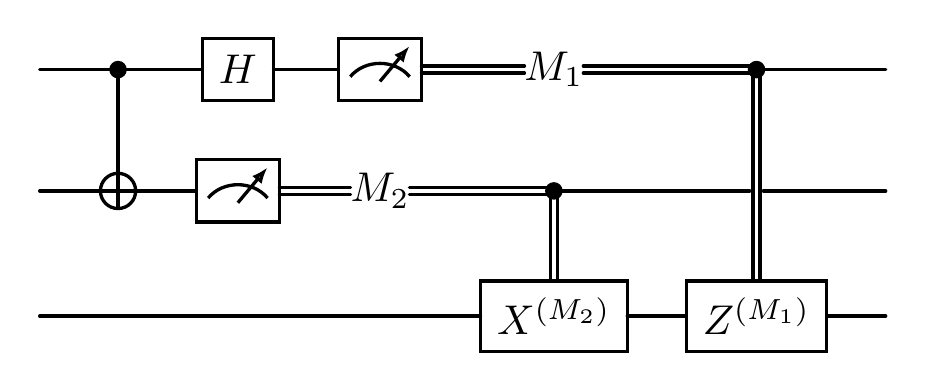

The two top lines represent Alice’s system, while the bottom line is Bob’s system. The meters represent measurement, and the double lines coming out of them carry classical bits (recall that single lines denote qubits).


In [5]:
print("the diagram of the quantum state teleportation in this case:")
cir.plot()
print("The two top lines represent Alice’s system, while the bottom line is Bob’s system. The meters represent measurement, and the double lines coming out of them carry classical bits (recall that single lines denote qubits).")

After running the teleportation circuit, there are 4 measurement branches per input state (one for each combination of Alice’s two classical bits), so we have 100 × 4 = 400 out put states.

In [6]:
output_state = cir(input_state).trace([0, 1])

We then use the `expect_state` attribute to collapse those 400 conditioned states back into a batch of 100 “expected” states.  

Finally, we compare the teleported state with the original state by computing the minimum fidelity across the four possible measurement outcomes.

In [7]:
result = state_fidelity(output_state.expec_state(), psi)
print("The average fidelity of the qubit teleportation protocol on all outcomes and 100 random states is:", result.mean().item())

The average fidelity of the qubit teleportation protocol on all outcomes and 100 random states is: 1.000000002698434


## W-state Distribution

W‐state distribution is a protocol where Alice uses LOCC with $N$ pairs of maximally entangled qubits to distribute an $N$‑qubit W-state $\ket{W_N}$ to Bob, who is spatially separated[4]. where 
$$
\ket{W_N} = \frac{1}{\sqrt{N}} \sum_{k = 1}^N X_k \ket{0}^{\otimes N}.\tag{12}
$$

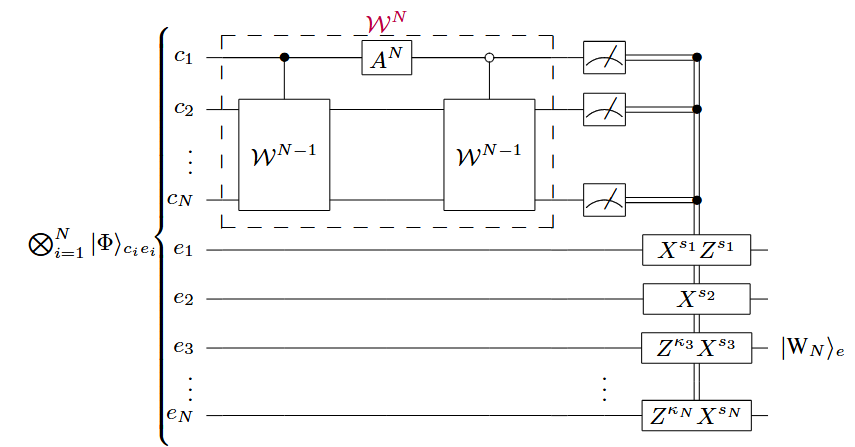



As illustrated above, the figure above shows protocols for distributing generalized N-qubit $W$‑states for $N\ge3$. 

In this setting, each end node $e_i$ pre‑shares $N$ Bell states with the central node $c_i$, and the local operation on each end node $e_i$ depends on the measured outcomes $s=s_1\cdots s_N\in\{0,1\}^N$. So, each pair of qubits $(c_1, e_1), (c_2, e_2), \dots, (c_N, e_N)$ forms a maximally entangled state shared between Alice and Bob. Alice holds the $c_i$ qubits, while Bob holds the corresponding $e_i$ qubits.

To begin the protocol, Alice applies a global quantum operator $\mathcal{W}^{N}$ to her $N$ qubits. She then performs a projective measurement in the computational basis and sends the resulting classical bitstring to Bob. Upon receiving this information, Bob applies a specific combination of Pauli gates to his $N$ qubits based on Alice's message. After these local corrections, Bob’s qubits changes into the desired $W$-state.

In the following, we will present the precise mathematical formulation of this protocol along with its implementation in code.

Below we show how to implement this in QuAIRKit with $N = 6$.

In [8]:
N = 6
_x, _z, _eye = x(), z(), eye()

First, Alice prepares the $N$‑qubit W operator $\mathcal{W}^N$, defined as:
$$
\mathcal{W}^N = \frac{1}{\sqrt{N}} \sum_{r=1}^N
\bigl(I^{\otimes(r-1)} \otimes X \otimes I^{\otimes(N-r)}\bigr). \tag{13}
$$
This operator will act on Alice’s half of the entangled pairs.


In [9]:
W_N = sum(
    nkron(kron_power(_z, r - 1), _x, kron_power(_eye, N - r))
    for r in range(1, N + 1)
)
W_N = W_N / torch.sqrt(torch.tensor(N, dtype=W_N.dtype))


Next, depending on the measurement result $s = s_1 \cdots s_N$, the $k$-th end node can correspondingly perform the single-qubit recovery unitary 
$$
V_k(s) =
\begin{cases}
X^{s_k}\,Z^{s_k}, & \text{if } k = 1,\\
X^{s_k},         & \text{if } k = 2,\\
Z^{\kappa_k}\,X^{s_k}, & \text{if } 3 \le k \le N,
\end{cases} \tag{14}
$$
where 
$$
\kappa_k \;=\; \Bigl(\sum_{l=2}^{\,k-1} s_l\Bigr) \bmod 2.\tag{15}
$$
Tracing out the central system would finally obtain the recovered state $\lvert W_N \rangle$, across $N$ end nodes.


In [10]:
def V(i: int) -> torch.Tensor:
    r"""Constructs the batched unitary operator V_i for the W-state distribution protocol.
    """
    
    s = list(map(int, bin(i)[2:].zfill(N)))
    
    list_u = [torch.matrix_power(_x, s[0]) @ torch.matrix_power(_z, s[0]),
              torch.matrix_power(_x, s[1]),]
    
    for r in range(2, N):
        kappa_r = sum(s[l] for l in range(1, r)) % 2
        
        list_u.append(torch.matrix_power(_z, kappa_r) @ torch.matrix_power(_x, s[r]))
    return nkron(*list_u)

V = torch.stack([V(i) for i in range(2 ** N)])

We define our target be the $N$‑qubit W:

In [11]:
target_state = w_state(N)

Now we build the $2N$‑qubit circuit. First we apply the oracle $\mathcal{W}_N$ on Alice’s qubits, then the one‑way LOCC step uses `locc` to apply the stacked correction operators $V$ based on Alice’s measurement outcomes. We name the circuit `cirw` to distinguish it from the first example.


In [12]:
cir = Circuit(2 * N)
cir.oracle(W_N, list(range(N)), latex_name=r'\mathcal{W}_N')
cir.locc(V, [list(range(N))] + [idx + N for idx in range(N)], label=r'M', latex_name=r'V')

We can visualize the circuit:

the diagram of the W-state distribution in this case:


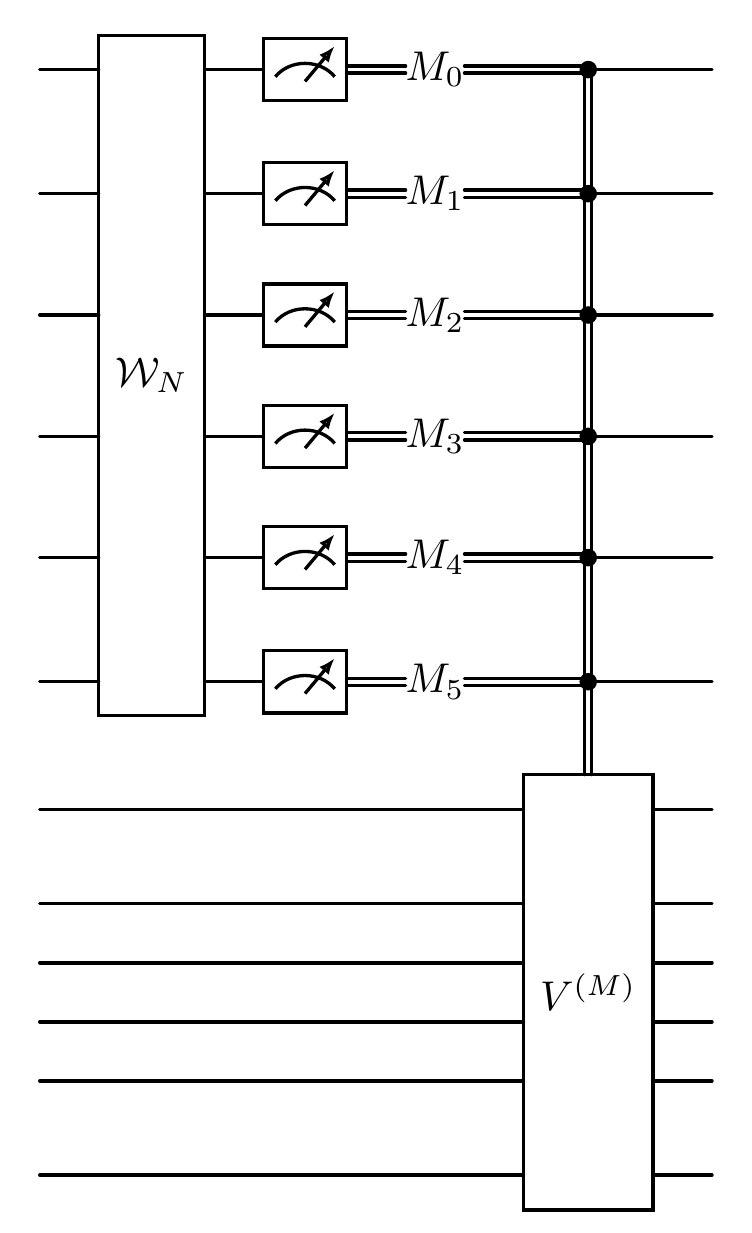

The six top lines represent Alice’s system, while the bottom line is Bob’s system. The meters represent measurement, and the double lines coming out of them carry classical bits (recall that single lines denote qubits).


In [13]:
print("the diagram of the W-state distribution in this case:")
cir.plot()
print("The six top lines represent Alice’s system, while the bottom line is Bob’s system. The meters represent measurement, and the double lines coming out of them carry classical bits (recall that single lines denote qubits).")

As before, the input state is $N$ Bell pairs, interleaved so that odd qubits are Alice’s and even qubits are Bob’s. After running the circuit and tracing out Alice’s qubits, Bob’s $N$‑qubit output should be the teleported W state.

The first line of the following code creates N Bell pairs by taking the tensor product of the 2‑qubit Bell state N times, which initially orders the qubits as $(c_1, c_2, \dots, c_n, e_1, e_2, \dots, e_n)$. The second line uses `permute` with the indices `[0, 2, 4, …, 2N−2, 1, 3, 5, …, 2N−1]` to interleave Alice’s and Bob’s qubits into $(c_1, e_1, c_2, e_2, \dots, c_n, e_n)$
, ensuring that each Bell pair is aligned on consecutive wires (even index for Alice and the next odd index for Bob) as required by the circuit.



In [14]:
input_state = to_state(kron_power(bell_state(2).ket, N))
input_state = input_state.permute(
    list(range(0, 2 * N - 1, 2)) + list(range(1, 2 * N, 2))
)


output_state = cir(input_state).product_trace(std_basis(N), list(range(N)))

Finally, we compute the fidelity between Bob’s output and the ideal W state to confirm successful distribution.


In [15]:
result = state_fidelity(output_state, target_state)
print("The fidelity of the W-state distribution protocol on each outcome is:\n", result.tolist())

The fidelity of the W-state distribution protocol on each outcome is:
 [1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.0000000234658166, 1.000000

---

## References

[1] Nielsen, Michael A., and Isaac L. Chuang. Quantum computation and quantum information. Cambridge university press, 2010.

[2]Bennett, Charles H., et al. "Teleporting an unknown quantum state via dual classical and Einstein-Podolsky-Rosen channels." Physical review letters 70.13 (1993): 1895.

[3] Kribs, David W., et al. "Operator structures and quantum one-way LOCC conditions." Journal of Mathematical Physics 58.9 (2017).

[4] Chen, Yu-Ao, et al. "Quantum Entanglement Allocation through a Central Hub." arXiv preprint arXiv:2409.08173 (2024).

[5] Laurenza, Riccardo, et al. "Channel simulation in quantum metrology." Quantum Measurements and Quantum Metrology 5.1 (2018): 1-12.

[6] Pirandola, Stefano, et al. "Fundamental limits of repeaterless quantum communications." Nature communications 8.1 (2017): 15043.

[7] Bennett, Charles H., David P. DiVincenzo, and John A. Smolin. "Capacities of quantum erasure channels." Physical Review Letters 78.16 (1997): 3217.

[8] Weedbrook, Christian, et al. "Gaussian quantum information." Reviews of Modern Physics 84.2 (2012): 621-669.

[9] Laurenza, Riccardo, et al. "Tight bounds for private communication over bosonic Gaussian channels based on teleportation simulation with optimal finite resources." Physical Review A 100.4 (2019): 042301.

[10] Laurenza, Riccardo, and Stefano Pirandola. "General bounds for sender-receiver capacities in multipoint quantum communications." Physical Review A 96.3 (2017): 032318.

[11] Pirandola, Stefano. "Capacities of repeater-assisted quantum communications." arXiv preprint arXiv:1601.00966 (2016).

[12] Laurenza, Riccardo, et al. "Rate limits in quantum networks with lossy repeaters." Physical Review Research 4.2 (2022): 023158.

[13] Pirandola, Stefano. "End-to-end capacities of a quantum communication network." Communications Physics 2.1 (2019): 51.

[14] Pirandola, Stefano, et al. "Advances in photonic quantum sensing." Nature Photonics 12.12 (2018): 724-733.

[15] Pirandola, Stefano, and Cosmo Lupo. "Ultimate precision of adaptive noise estimation." Physical Review Letters 118.10 (2017): 100502.

[16] Zhou, Sisi, and Liang Jiang. "Asymptotic theory of quantum channel estimation." PRX Quantum 2.1 (2021): 010343.

[17] Zhuang, Quntao, and Stefano Pirandola. "Ultimate limits for multiple quantum channel discrimination." Physical Review Letters 125.8 (2020): 080505.

[18] Pirandola, Stefano, et al. "Fundamental limits to quantum channel discrimination." npj Quantum Information 5.1 (2019): 50.

[19] Sedlák, Michal, Alessandro Bisio, and Mário Ziman. "Optimal probabilistic storage and retrieval of unitary channels." Physical Review Letters 122.17 (2019): 170502.

[20] Banchi, Leonardo, et al. "Convex optimization of programmable quantum computers." npj Quantum Information 6.1 (2020): 42.

[21] Kubicki, Aleksander M., Carlos Palazuelos, and David Pérez-García. "Resource quantification for the no-programing theorem." Physical Review Letters 122.8 (2019): 080505.

[22] Pereira, Jason, Leonardo Banchi, and Stefano Pirandola. "Characterising port-based teleportation as universal simulator of qubit channels." Journal of Physics A: Mathematical and Theoretical 54.20 (2021): 205301.

[23] Lipka-Bartosik, Patryk, and Paul Skrzypczyk. "Catalytic quantum teleportation." Physical Review Letters 127.8 (2021): 080502.

[24] Yoshida, Beni, and Norman Y. Yao. "Disentangling scrambling and decoherence via quantum teleportation." Physical Review X 9.1 (2019): 011006.

[25] Schuster, Thomas, et al. "Many-body quantum teleportation via operator spreading in the traversable wormhole protocol." Physical Review X 12.3 (2022): 031013.

[26] Chen, Ming-Cheng, et al. "Directly measuring a multiparticle quantum wave function via quantum teleportation." Physical Review Letters 127.3 (2021): 030402.

[27] Hou, P-Y., et al. "Quantum teleportation from light beams to vibrational states of a macroscopic diamond." Nature communications 7.1 (2016): 11736.

[28] Sun, Kai, et al. "Experimental quantum entanglement and teleportation by tuning remote spatial indistinguishability of independent photons." Optics Letters 45.23 (2020): 6410-64113.

[29] Li, Jyun-Yi, et al. "Activating hidden teleportation power: Theory and experiment." Physical Review Research 3.2 (2021): 023045.

[30] Hu, Xiao-Min, et al. "Progress in quantum teleportation." Nature Reviews Physics 5.6 (2023): 339-353.



*Table: A reference of notation conventions in this tutorial.*

| Symbol                                      | Variant                                | Description                                                                                     |
|:--------------------------------------------:|:--------------------------------------:|:------------------------------------------------------------------------------------------------|
| $\ket{\Phi^+}$        |         | a maximally entangled Bell state: $\tfrac1{\sqrt2}(\ket{00} + \ket{11})$                       || $\mathcal{M}_c^s$                           |                                        | measurement operator on central qubits $c_1\cdots c_N$ yielding outcome $s$                     |
| $\mathcal{R}_{e_k}^{k,\alpha_k(s)}$         |                                        | local recovery operation by end node $e_k$ upon receiving classical outcome $\alpha_k(s)$      |
| $\alpha_k(s)$                               |                                        | the classical information sent to node $k$ based on outcome $s$                                 |
| $\ket{W_N}$                                 |                                        | the $N$-qubit W‐state distributed by the protocol                                               |
| $\mathcal{L}$           |                              | The one-way LOCC operation             |
| $X, Y, Z$           |                              | Pauli matrices             |
| $\mathcal{M}_x$           |                              | Measurement operator             |
| $c_i, e_i$           |                              | Nodes in W-state Distribution protocol        |
| $\rho$           |                              | Density matrix of a quantum state        |
| $\Phi_x$           |                              | A CPTP map that depends on the measurement outcome $x$      |

In [16]:
qkit.print_info()


---------VERSION---------
quairkit: 0.4.2
torch: 2.8.0+cu128
torch cuda: 12.8
numpy: 2.2.6
scipy: 1.15.3
matplotlib: 3.10.6
---------SYSTEM---------
Python version: 3.10.18
OS: Linux
OS version: #1 SMP Tue Nov 5 00:21:55 UTC 2024
---------DEVICE---------
CPU:  13th Gen Intel(R) Core(TM) i9-13980HX
GPU: (0) NVIDIA GeForce RTX 4090 Laptop GPU
